In [1]:
import os
import datetime

import numpy as np
import pandas as pd

import astropy.units as u
from astropy.timeseries import TimeSeries
from astropy.table import Table
from astropy.time import Time

import matplotlib.pyplot as plt
import scienceplots
plt.style.use("science")

DATA_FILE_PATH = "/home/ramon/uanl/thesis/Backup Data/Iturbide/ATOJ339.9469+45.1464_SPM.dat"
DATA_FILE_PATH

'/home/ramon/uanl/thesis/Backup Data/Iturbide/ATOJ339.9469+45.1464_SPM.dat'

In [2]:
allObjDf = Table.read(DATA_FILE_PATH, format='ascii').to_pandas()
allObjDf.columns = ['fname', 'filter', 'exptime', 'hjd', 'airmass', 
					  'mag1', 'mag2', 'mag3', 'mag4', 'mag5', 'mag6', 'mag7', 
					  'err1', 'err2', 'err3', 'err4', 'err5', 'err6', 'err7']
allObjDf = allObjDf[(allObjDf['err1'] < 1) & (allObjDf['err5'] < 90)] # removing most egregious data points
allObjDf

,fname,filter,exptime,hjd,airmass,mag1,mag2,mag3,mag4,mag5,mag6,mag7,err1,err2,err3,err4,err5,err6,err7
0,s_0001o.fit,W,60.0,2.459875e+06,1.076,19.5253,16.7627,18.4668,17.8910,18.3033,18.3373,17.7953,0.019,0.003,0.009,0.006,0.008,0.008,0.006
1,s_0002o.fit,W,60.0,2.459875e+06,1.077,19.4874,16.7586,18.4767,17.8835,18.2984,18.3346,17.7884,0.016,0.003,0.008,0.006,0.007,0.007,0.005
2,s_0003o.fit,W,60.0,2.459875e+06,1.077,19.5269,16.7615,18.4741,17.8885,18.2952,18.3356,17.7870,0.015,0.003,0.008,0.006,0.007,0.007,0.005
3,s_0004o.fit,W,60.0,2.459875e+06,1.078,19.4836,16.7533,18.4543,17.8807,18.3064,18.3241,17.7936,0.016,0.003,0.008,0.006,0.007,0.007,0.006
4,s_0005o.fit,W,60.0,2.459875e+06,1.078,19.4708,16.7678,18.4633,17.8942,18.3105,18.3356,17.8094,0.015,0.003,0.008,0.006,0.007,0.007,0.006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1267,s_1268o.fit,W,60.0,2.459925e+06,1.310,19.8010,16.8106,18.5280,17.9386,18.3342,18.4044,17.8468,0.020,0.003,0.009,0.006,0.008,0.008,0.006
1268,s_1269o.fit,W,60.0,2.459925e+06,1.313,19.7907,16.8007,18.5086,17.9294,18.3472,18.3877,17.8116,0.021,0.003,0.009,0.006,0.008,0.008,0.006
1269,s_1270o.fit,W,60.0,2.459925e+06,1.316,19.8209,16.7875,18.5010,17.9217,18.3390,18.3683,17.8051,0.026,0.003,0.009,0.006,0.008,0.008,0.006
1270,s_1271o.fit,W,60.0,2.459925e+06,1.320,19.8697,16.8008,18.5043,17.9267,18.3425,18.3677,17.8264,0.023,0.003,0.009,0.006,0.008,0.008,0.006


In [3]:
COMP_ID = 5
atoDiffMag = pd.DataFrame(columns=['hjd', 'mag', 'err', 'filter', 'airmass', 'exptime'])
atoDiffMag['hjd'] = allObjDf['hjd']
atoDiffMag['mag'] = allObjDf['mag1'] - allObjDf[f'mag{COMP_ID}']
atoDiffMag['err'] = np.sqrt(np.power(allObjDf['err1'], 2) + np.power(allObjDf[f'err{COMP_ID}'], 2))
atoDiffMag['filter'] = 'W'
atoDiffMag['exptime'] = allObjDf['exptime']
atoDiffMag['airmass'] = allObjDf['airmass']
atoDiffMag

,hjd,mag,err,filter,airmass,exptime
0,2.459875e+06,1.2220,0.020616,W,1.076,60.0
1,2.459875e+06,1.1890,0.017464,W,1.077,60.0
2,2.459875e+06,1.2317,0.016553,W,1.077,60.0
3,2.459875e+06,1.1772,0.017464,W,1.078,60.0
4,2.459875e+06,1.1603,0.016553,W,1.078,60.0
...,...,...,...,...,...,...
1267,2.459925e+06,1.4668,0.021541,W,1.310,60.0
1268,2.459925e+06,1.4435,0.022472,W,1.313,60.0
1269,2.459925e+06,1.4819,0.027203,W,1.316,60.0
1270,2.459925e+06,1.5272,0.024352,W,1.320,60.0


In [5]:
def hjd_to_observation_date(hjd: float) -> str:
    t = Time(hjd, format='jd', scale='utc')
    return t.strftime(r"%Y-%m-%d")
atoDiffMag['obsv_date'] = atoDiffMag['hjd'].apply(hjd_to_observation_date)
atoDiffMag

,hjd,mag,err,filter,airmass,exptime,obsv_date
0,2.459875e+06,1.2220,0.020616,W,1.076,60.0,2022-10-22
1,2.459875e+06,1.1890,0.017464,W,1.077,60.0,2022-10-22
2,2.459875e+06,1.2317,0.016553,W,1.077,60.0,2022-10-22
3,2.459875e+06,1.1772,0.017464,W,1.078,60.0,2022-10-22
4,2.459875e+06,1.1603,0.016553,W,1.078,60.0,2022-10-22
...,...,...,...,...,...,...,...
1267,2.459925e+06,1.4668,0.021541,W,1.310,60.0,2022-12-11
1268,2.459925e+06,1.4435,0.022472,W,1.313,60.0,2022-12-11
1269,2.459925e+06,1.4819,0.027203,W,1.316,60.0,2022-12-11
1270,2.459925e+06,1.5272,0.024352,W,1.320,60.0,2022-12-11


In [7]:
observationsTs = TimeSeries(time=Time(atoDiffMag['hjd'], format='jd', scale='utc'), 
            data={'mag': atoDiffMag['mag']*u.mag, 'err': atoDiffMag['err']*u.mag, 
                  'obsv_date': atoDiffMag['obsv_date'], 
                  'hjd': atoDiffMag['hjd']})
observationsTs

time,mag,err,obsv_date,hjd
Time,float64,float64,object,float64
2459874.66590992,1.2220000000000013,0.0206155281280883,2022-10-22,2459874.66590992
2459874.66661048,1.189,0.01746424919657298,2022-10-22,2459874.66661048
2459874.6673093,1.2317,0.01655294535724685,2022-10-22,2459874.6673093
2459874.6680094,1.1771999999999991,0.01746424919657298,2022-10-22,2459874.6680094
2459874.66870811,1.1602999999999994,0.01655294535724685,2022-10-22,2459874.66870811
2459874.66940867,1.2020000000000017,0.01746424919657298,2022-10-22,2459874.66940867
2459874.67010726,1.1966999999999999,0.01655294535724685,2022-10-22,2459874.67010726
2459874.67080979,1.1867000000000019,0.01969771560359221,2022-10-22,2459874.67080979
2459874.67150849,1.2080999999999982,0.018788294228055936,2022-10-22,2459874.67150849


In [8]:
%%script echo "skipping; already have HJD time from IRAF results"

# light travel time correction

from astropy.coordinates import EarthLocation, SkyCoord

atoCoord = SkyCoord.from_name("ATO J339.9469+45.1464")
iturbideLocation = EarthLocation(lon=-99.895328*u.deg, lat=24.75521 * u.deg, height=2400*u.m)
helioCorrection = observationsTs.time.light_travel_time(atoCoord, kind='heliocentric', location=iturbideLocation)
observationsTs['hjd'] = observationsTs.time + helioCorrection
observationsTs

skipping; already have HJD time from IRAF results


In [15]:
%%script echo "skipping; already have this graph in other notebook"

# normalized flux synced in time

# %matplotlib widget

import astropy.units as u
import numpy as np
from astropy.timeseries import TimeSeries
from astropy.time import Time

from dateutil.parser import parse

JD_OFFSET = 2459000

tsObsvDates = atoDiffMag['obsv_date'].unique()
# fig, axs = plt.subplots(nrows=1, ncols=len(tsObsvDates), sharey=True, figsize=(15, 6))
magFig, magAxs = plt.subplots(nrows=1, ncols=len(tsObsvDates), sharey=True, figsize=(15, 6))

# for d, ax, magAx in zip(tsObsvDates, axs, magAxs):
for d, magAx in zip(tsObsvDates, magAxs):
    dateTs = observationsTs[observationsTs['obsv_date'] == d]
    # ax.errorbar(observationsTs['hjd'] - JD_OFFSET, observationsTs['raw_flux'], observationsTs['ferr'], fmt='k.', markersize=3)
    magAx.errorbar(observationsTs['hjd'] - JD_OFFSET, observationsTs['mag'], observationsTs['err'], fmt='k.', markersize=3)
    baseMinDayTime = Time(parse(f"{dateTs['obsv_date'][0]}T18:10:00-05:00"))
    baseMaxDayTime = Time(parse(f"{dateTs['obsv_date'][0]}T05:32:00-05:00")) + 1*u.day

    # ax.set_xlim(baseMinDayTime.jd - JD_OFFSET, baseMaxDayTime.jd - JD_OFFSET)
    magAx.set_xlim(baseMinDayTime.jd - JD_OFFSET, baseMaxDayTime.jd - JD_OFFSET)
    
    # ax.set_title(d)
    magAx.set_title(d)

# fig.supylabel("Flux (count)")
magFig.supylabel("Magnitude")

# fig.supxlabel(f"HJD +{JD_OFFSET}")
magFig.supxlabel(f"HJD +{JD_OFFSET}")

# fig.tight_layout()
magFig.tight_layout()

plt.figure(figsize=(15,6))
plt.errorbar(observationsTs['hjd'] - JD_OFFSET, observationsTs['mag'], observationsTs['err'], fmt='k.', markersize=3)
plt.xlabel(f"HJD +{JD_OFFSET}")
plt.ylabel("Magnitude")
plt.tight_layout()

skipping; already have this graph in other notebook


2022-10-22 (2.6740048862993704 h h) | 2459874.66590992 | 2459874.77732679
	   | 874.6663381606285 | 874.777755030891
2022-10-23 (5.278720557689665 h h) | 2459875.57414223 | 2459875.79408892
	   | 875.5745704709497 | 875.7945171608534
2022-10-28 (2.113356962800026 h h) | 2459880.77049394 | 2459880.85855048
	   | 880.7709221807253 | 880.858978720842
2022-11-06 (4.246935836970804 h h) | 2459889.58176454 | 2459889.7587202
	   | 889.5821927809101 | 889.7591484407839
2022-12-07 (5.25088584423065 h h) | 2459920.55271792 | 2459920.77150483
	   | 920.5531461606678 | 920.771933070844
2022-12-08 (4.251083515584469 h h) | 2459921.56536557 | 2459921.74249405
	   | 921.5657938108724 | 921.7429222906884
2022-12-09 (4.970458321273327 h h) | 2459922.53610982 | 2459922.74321225
	   | 922.536538060749 | 922.743640490802
2022-12-10 (5.444495514035223 h h) | 2459923.54353401 | 2459923.77038799
	   | 923.5439622509238 | 923.7708162306752
2022-12-11 (2.2028025537729263 h h) | 2459924.53232525 | 2459924.62410

/home/ramon/anaconda3/envs/mapta-tesis/lib/python3.12/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


Text(0, 0.5, 'Duration [h]')

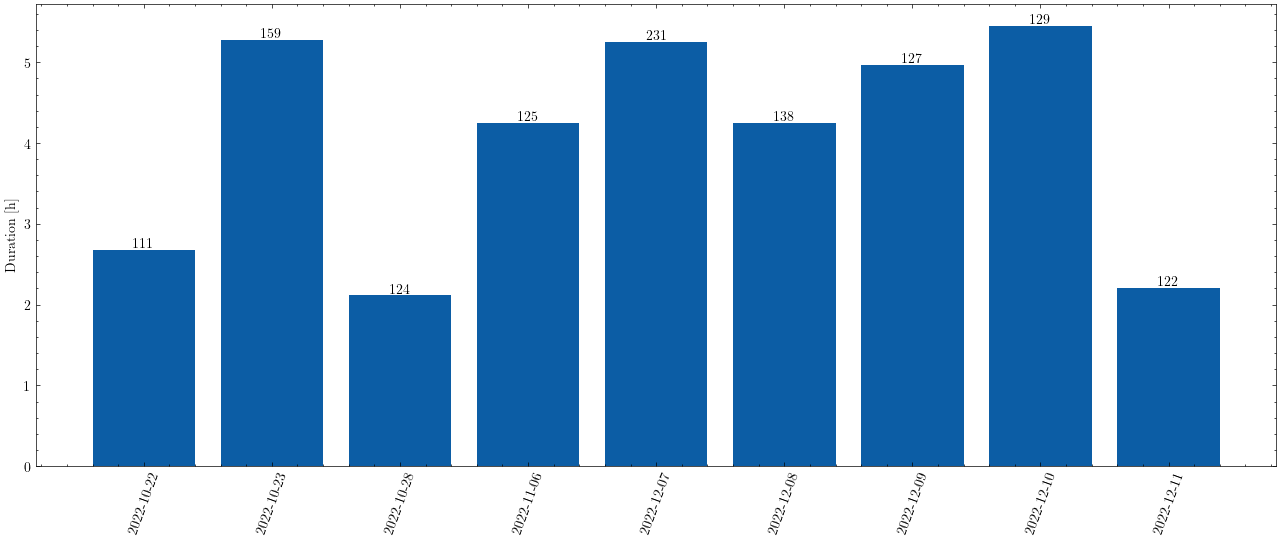

In [21]:
# observation duration bar chart

# %matplotlib widget

import numpy as np

JD_OFFSET = 2459000

tsObsvDates = atoDiffMag['obsv_date'].unique()
obsvDatesDurations = []
obsvCounts = []
for i, d in enumerate(tsObsvDates):
    obsvData = atoDiffMag[atoDiffMag['obsv_date'] == d]
    obsvStart = Time(obsvData['hjd'].iloc[0], format='jd', scale='utc')
    obsvEnd = Time(obsvData['hjd'].iloc[-1], format='jd', scale='utc')
    durationHours = (obsvEnd - obsvStart).to(u.hour)
    obsvDatesDurations.append(durationHours.value)
    obsvCounts.append(len(obsvData))
    print(f"{d} ({durationHours} h)", obsvStart, obsvEnd, sep=" | ")
    print("\t  ", obsvStart - JD_OFFSET, obsvEnd - JD_OFFSET, sep=" | ")

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 6))
ax.bar(np.arange(len(tsObsvDates)), obsvDatesDurations)

rects = ax.patches
for rect, label in zip(rects, obsvCounts):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height, label, ha="center", va="bottom")

ax.set_xticks(np.arange(len(tsObsvDates)), tsObsvDates, rotation=70)
ax.set_ylabel("Duration [h]")

# Lomb-Scargle Periodogram

Manually calculating Iturbide period using Astropy Lomb-Scargle periodogram.

Grid size: 23979.9354095757
Periodo: 4.002003087745908 h
Frecuencia: 5.996996872263231 1 / d


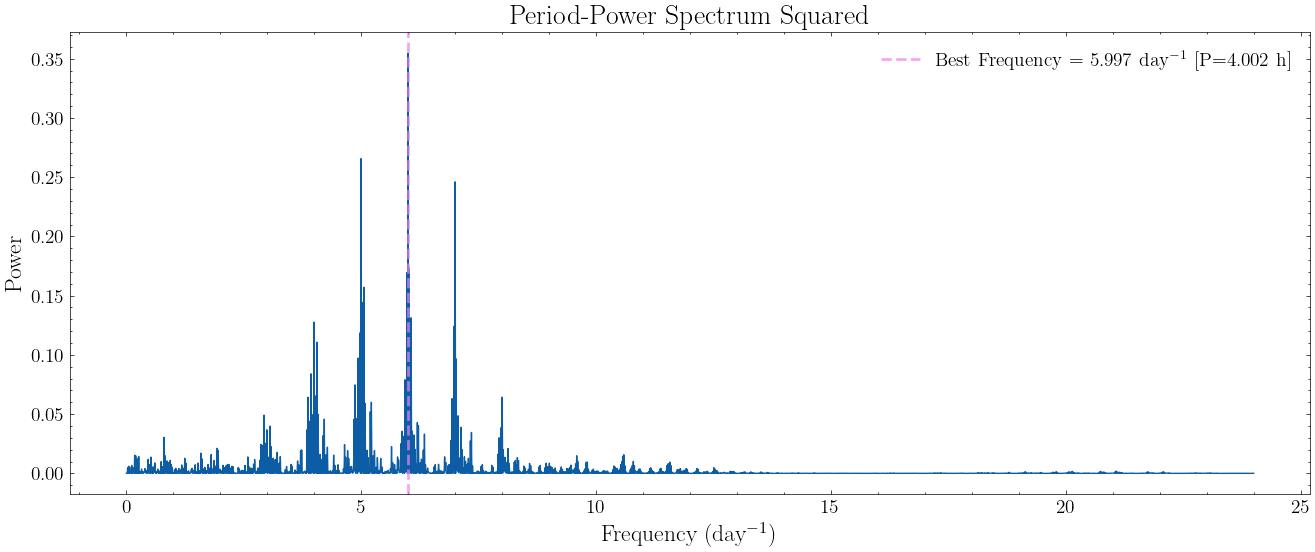

In [33]:
import astropy.units as u
from astropy.timeseries import LombScargle

figure, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 6))

MIN_FREQ = 0.001
# MAX_FREQ = (1 / (2*(60*u.second).to(u.day))).value # windowing limit windowed observations, taking delta-t = 60sec
MAX_FREQ = 24 # 1 hour period

N_0 = 20
GRID_SIZE = N_0 * (observationsTs.time.jd[-1] - observationsTs.time.jd[0]) * float(MAX_FREQ)
print(f"Grid size: {GRID_SIZE}")

# setting a much finer grid for lower frequencies, since this is where we expect the orbital period to be
sub1 = np.linspace(MIN_FREQ, MAX_FREQ, int(GRID_SIZE), endpoint=False)
# sub2 = np.linspace(12, float(MAX_FREQ), int(GRID_SIZE) // 100)
# manualFreqSample = np.concatenate([sub1, sub2])
manualFreqSample = sub1

model = LombScargle.from_timeseries(observationsTs, signal_column_name='mag')
freqs = manualFreqSample * (1/u.day)

explicitPeriodogram = model.power(freqs)
bestFreq = freqs[np.argmax(explicitPeriodogram)]
bestPeriod = 1.0 / bestFreq
ax.plot(freqs, np.power(explicitPeriodogram, 2))
ax.axvline(bestFreq.value, color='violet', linestyle='--', label=f"Best Frequency = {bestFreq.value:0.3f} day$^{{-1}}$ [P={bestPeriod.to(u.hour):0.3f}]", linewidth=2, alpha=0.7)
# ax.axvline(bestFreq.value*2, color='indigo', linestyle='--', label=f"Best Frequency (2nd harmonic) = {bestFreq.value*2:0.3f} day$^{{-1}} [$P={bestPeriod.to(u.hour)*2:0.3f}$]$", linewidth=2, alpha=0.7)

ax.set_title("Period-Power Spectrum Squared", fontsize=20)
ax.set_xlabel("Frequency (day$^{-1}$)", fontsize=17)
ax.set_ylabel("Power", fontsize=17)
ax.tick_params(axis='both', labelsize=14)

ax.legend(fontsize=14)
print(f"Periodo: {bestPeriod.to(u.hour)}")
print(f"Frecuencia: {1.0 / bestPeriod}")

In [9]:
%%script echo "skipping for LS; need to figure out transits for LS"

index = np.argmax(explicitPeriodogram.power)

period = explicitPeriodogram.period[index]
transitTime = explicitPeriodogram.transit_time[index]
transitDuration = explicitPeriodogram.duration[index]

periodogramStats = model.compute_stats(period, transitDuration, transitTime)
periodogramStats

skipping for LS; need to figure out transits for LS


In [10]:
%%script echo "skipping for LS; need to figure out transits for LS"

figure, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 6))

ax.plot(objTimeSeries.time.jd, objTimeSeries['flux'], 'k.', markersize=3, label="Original")

i = 0
for tt in periodogramStats['transit_times']:
    if periodogramStats['per_transit_count'][i] != 0 or i % 5 == 0:
        lineColor = "blue" if periodogramStats['per_transit_count'][i] != 0 else "orange"
        ax.axvline(tt.jd, linestyle='--', color=lineColor, alpha=0.5)
    i = i + 1

skipping for LS; need to figure out transits for LS


# Phase Plot

/tmp/ipykernel_9882/2997942812.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


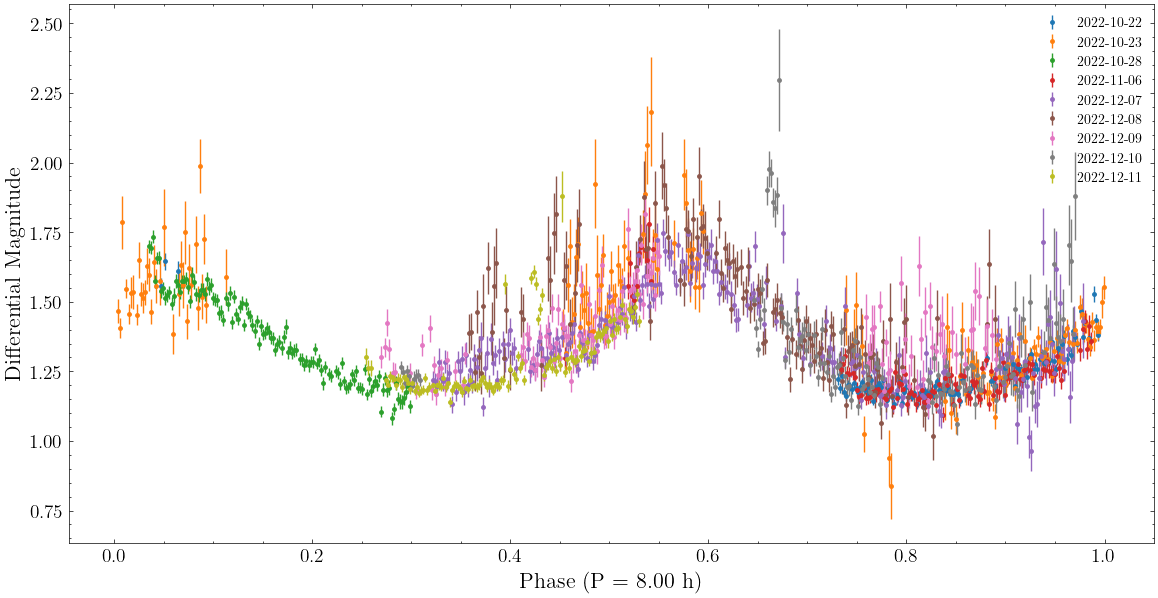

In [30]:
import numpy as np
from matplotlib import cm

# bestPeriod = 0.1667834993*u.day # taken from IRSA periodogram
periodHarmonic = 2
period = bestPeriod*periodHarmonic

tsObsvDates = atoDiffMag['obsv_date'].unique()

cmap = cm.get_cmap('tab10')
dateColors = [cmap(c) for c in np.linspace(0.001, 1, len(tsObsvDates), endpoint=False)]

figure, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 7))
minIndex = np.argmin(observationsTs[observationsTs['obsv_date'] == tsObsvDates[5]]['mag'])
foldedTs = observationsTs.fold(period=period, epoch_time=observationsTs.time[minIndex], normalize_phase=True)
for obsvDate, color in zip(tsObsvDates, dateColors):
    obsvPoints = foldedTs[foldedTs['obsv_date'] == obsvDate]
    ax.errorbar(obsvPoints.time.value + 0.5, obsvPoints['mag'], obsvPoints['err'], fmt='.', color=color, markersize=5, label=obsvDate)
    # ax.plot(obsvPoints.time.value, obsvPoints['raw_flux'], '.', color=color, markersize=5, label=obsvDate)
ax.legend()

ax.set_xlabel(f"Phase (P = {period.value * 24:.2f} h)", fontsize=16)
ax.set_ylabel("Differential Magnitude", fontsize=16)

ax.tick_params(labelsize=14)

# Normalized Flux

Calculating normalized flux from phase-folded light curve according to [PHOEBE recommendations](https://github.com/phoebe-project/phoebe2/discussions/507#discussioncomment-1135476). Flux error propagation formula taken from [Astronomy Stack Exchange post](https://astronomy.stackexchange.com/questions/38371/how-can-i-calculate-the-uncertainties-in-magnitude-like-the-cds-does).

In [12]:
import math

def findClosestQuarterPhaseIdx(foldedTs: TimeSeries) -> int:
	adjustedPhases = foldedTs.time.value + 0.5 # so that phases go 0 -> 1
	diff = np.abs(adjustedPhases - 0.25)
	return np.argmin(diff)

quarterPhaseIdx = findClosestQuarterPhaseIdx(foldedTs)
quarterPhaseMag = foldedTs['mag'][quarterPhaseIdx]

foldedTs['norm_flux'] = 10**(-(2/5) * (foldedTs['mag'].value - quarterPhaseMag))
foldedTs['norm_ferr'] = (foldedTs['norm_flux'] * foldedTs['err'] * math.log(10)) / 2.5

observationsTs['norm_flux'] = 10**(-(2/5) * (observationsTs['mag'].value - quarterPhaseMag))
observationsTs['norm_ferr'] = (observationsTs['norm_flux'] * observationsTs['err'] * math.log(10)) / 2.5

/tmp/ipykernel_54246/4089566607.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


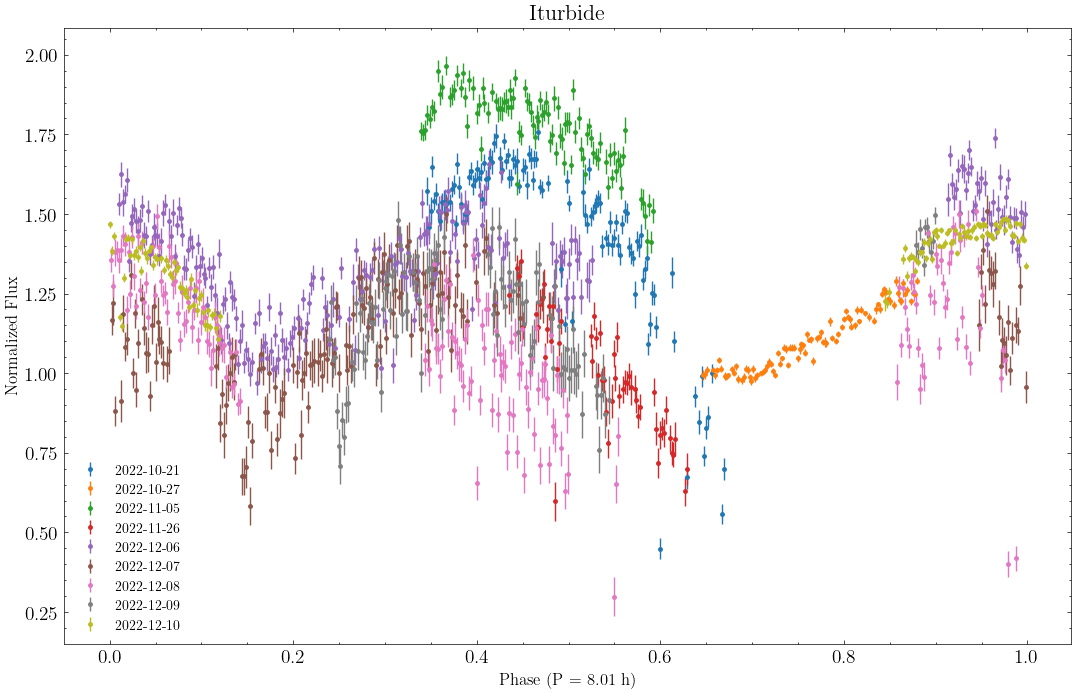

In [14]:
tsObsvDates = allObjDf['obsv_date'].unique()

cmap = cm.get_cmap('tab10')
dateColors = [cmap(c) for c in np.linspace(0.001, 1, len(tsObsvDates), endpoint=False)]

figure, ax = plt.subplots(nrows=1, ncols=1, figsize=(13, 8))
minIndex = np.argmin(observationsTs[observationsTs['obsv_date'] == tsObsvDates[5]]['raw_flux'])
for obsvDate, color in zip(tsObsvDates, dateColors):
    obsvPoints = foldedTs[foldedTs['obsv_date'] == obsvDate]
    ax.errorbar(obsvPoints.time.value + 0.5, obsvPoints['norm_flux'], obsvPoints['norm_ferr'], fmt='.', color=color, markersize=5, label=obsvDate)
ax.legend()

ax.set_title("Iturbide", fontsize=16)
ax.set_xlabel(f"Phase (P = {period.value * 24:.2f} h)", fontsize=12)
ax.set_ylabel("Normalized Flux", fontsize=12)

ax.tick_params(labelsize=14)

# results look good; export this to import into PHOEBE

/tmp/ipykernel_277439/803764385.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Text(0.5, 1.0, 'Iturbide')

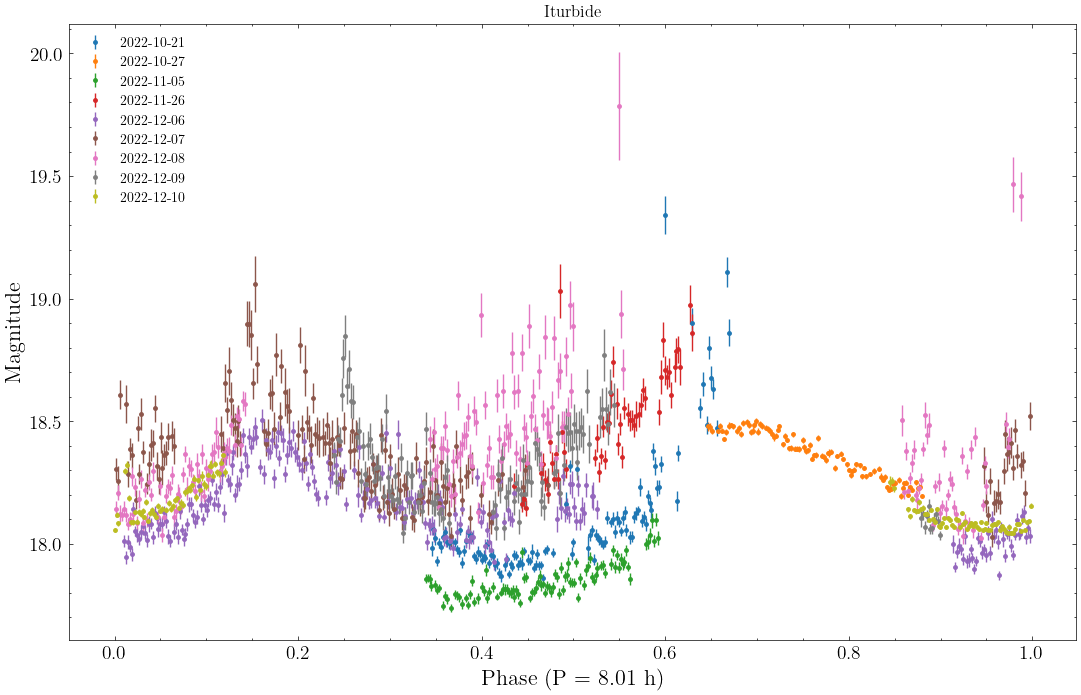

In [15]:
tsObsvDates = allObjDf['obsv_date'].unique()

cmap = cm.get_cmap('tab10')
dateColors = [cmap(c) for c in np.linspace(0.001, 1, len(tsObsvDates), endpoint=False)]

figure, ax = plt.subplots(nrows=1, ncols=1, figsize=(13, 8))
minIndex = np.argmin(observationsTs[observationsTs['obsv_date'] == tsObsvDates[5]]['raw_flux'])
for obsvDate, color in zip(tsObsvDates, dateColors):
    obsvPoints = foldedTs[foldedTs['obsv_date'] == obsvDate]
    ax.errorbar(obsvPoints.time.value + 0.5, obsvPoints['mag'], obsvPoints['err'], fmt='.', color=color, markersize=5, label=obsvDate)
ax.legend()

ax.set_xlabel(f"Phase (P = {period.value * 24:.2f} h)", fontsize=16)
ax.set_ylabel("Magnitude", fontsize=16)

ax.tick_params(labelsize=14)
ax.set_title("Iturbide")

In [24]:
observationsTs

time,mag,err,raw_flux,ferr,obsv_date,julianDate,hjd,norm_flux,norm_ferr
Time,float64,float64,float64,float64,object,float64,Time,float64,float64
2022-10-22 03:54:21.841000,17.981,0.031,112240.92842194808,1092.3324438632785,2022-10-21,2459874.663553512,2022-10-22 03:59:25.480471,1.571809828203918,0.04487840090510403
2022-10-22 03:55:22.219000,18.061,0.027,105232.83011050562,880.8971288902421,2022-10-21,2459874.664252331,2022-10-22 04:00:25.856822,1.4601584968117884,0.03631110323220811
2022-10-22 03:56:22.714000,18.024,0.03,107386.88636453748,1014.6543851649874,2022-10-21,2459874.6649525044,2022-10-22 04:01:26.350168,1.5107757319249953,0.041744276150251954
2022-10-22 03:57:23.081000,17.929,0.021,116882.9731974464,781.5124606011574,2022-10-21,2459874.6656511966,2022-10-22 04:02:26.715518,1.6489215731508369,0.03189297076436863
2022-10-22 03:58:23.606000,18.002,0.02,109585.0349264616,707.3017352352562,2022-10-21,2459874.6663517174,2022-10-22 04:03:27.238863,1.5417004529495628,0.028399171846590653
2022-10-22 03:59:23.970000,17.988,0.024,111007.22608631152,837.9538608606848,2022-10-21,2459874.667050375,2022-10-22 04:04:27.601213,1.5617085932653765,0.034521282493954156
2022-10-22 04:00:24.671000,18.026,0.02,106108.76269690807,688.9434511375254,2022-10-21,2459874.6677529328,2022-10-22 04:05:28.300553,1.5079953418017917,0.027778300754698133
2022-10-22 04:01:25.043000,18.049,0.022,104076.15767275717,733.3202872846815,2022-10-21,2459874.6684516827,2022-10-22 04:06:28.670901,1.476386277753865,0.029915644304981746
2022-10-22 04:02:25.528000,18.006,0.021,109081.537426456,732.7290009403191,2022-10-21,2459874.6691517406,2022-10-22 04:07:29.154246,1.5360310683850291,0.029709474819688324


In [25]:
import os

# foldedTs.to_pandas().to_csv(os.path.join(OBJ_DATA_DIR, "Iturbide", "normalized-phase-folded.csv"))
observationsTs.write(os.path.join(OBJ_DATA_DIR, "Iturbide", "normalized-data.ecsv"))